## Library

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

## SIR Model (Vanilla model)

#### **変数**

- **S(Susceptible)**  
伝染病に対する免疫がない者。感染可能者。
- **I Infectious)**  
感染により発病し、感染可能者(S)への伝染可能な者。感染者。
- **R (Removed)**  
発病から回復し、免疫を獲得したもの。あるいは発病から回復できず死亡した者。

#### **数理モデル**

$$
\begin{array}{l}\frac{d S}{d t}=-\beta S I \\ \frac{d I}{d t}=\beta S I-\gamma I \\ \frac{d R}{d t}=\gamma I\end{array}
$$

$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 感染後死亡者、もしくは免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
\end{array}
$$

**第1式の微分方程式**

左辺dS/dtは未感染者数Sの時間変化率（微分）。未感染者と感染者の接触により感染するので、接触率は両者の人数の積SIに比例する。

集団内では、1人が毎日接触する人数を平均m人、それぞれの接触毎に感染が生じる1日あたりの確率をpとしたとき、感染率β=mp/N。刻々と感染が起こると未感染人口Sは減少していく。

**第2式の微分方程式**

総人口N=S+I+R は定数であるため、時間微分は0となる。

0=dS/dt+dI/dt+dR/dt

これと第1式、第3式から第2式が得られる。

**第3式の微分方程式**

左辺dR/dtは回復者数Rの時間変化率（微分）。感染者が一定の速度γで回復していくとすると、刻々と回復する人が増加していく。1/γは感染期間が指数宇分布に従うと仮定した場合の平均値を表す。つまり、感染から回復もしくは隔離されるまでの平均感染性期間を指す。

#### **前提条件**

SIRモデルの前提条件

- 一度免疫を獲得した者は2度と感染することなく、免疫を失うこともない。
- 全体人口で外部からの流入及び流出はない。なお出生者及び感染以外の原因で死亡する者もいない。

In [13]:
# Define differential equation of SIR model
def SIR_EQ(v, t, beta, gamma):
    '''
    dS/dt = -beta * S * I
    dI/dt = beta * S * I - gamma * I
    dR/dt = gamma * I

    [v[0], v[1], v[2]] = [S, I, R]

    dv[0]/dt = -beta * v[0] * v[1]
    dv[1]/dt = beta * v[0] * v[1] - gamma * v[1]
    dv[2]/dt = gamma * v[1]
    '''
    dS_dt = -beta*v[0]*v[1]
    dI_dt = beta * v[0] * v[1] - gamma * v[1]
    dR_dt = gamma * v[1]

    # return [-beta*v[0]*v[1], beta * v[0] * v[1] - gamma * v[1], gamma * v[1]]
    return [dS_dt, dI_dt, dR_dt]    

In [15]:
# 人口1,000名の集団に対し、初期に感染者が1名がいたと仮定する。
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I_0 = 1
R_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m=10 # 1日1人あたりのに接触平均数
p=0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10 # 感染者の回復日数を10日とすると

# A grid of time points (in days)
times = np.linspace(0, 365, 365)
"""消しても良い
# parameters
# t_max = 160 # days
# dt = 0.01
# times =np.arange(0,t_max, dt)
"""

# R0
R0 = N * beta_const *(1/gamma_const)
print(f"基本再生産数 = {R0}")

基本再生産数 = 2.0


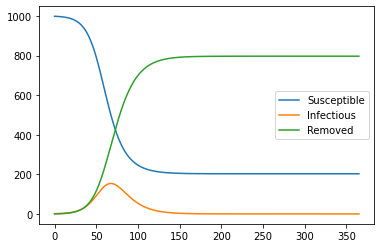

Final S=202.84590572748849
Final I=8.990242612832062e-06
Final R=797.1540852822698


In [16]:
# numerical integration
ini_state = [S_0,I_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIR model
result = odeint(SIR_EQ, ini_state, times, args=(beta_const, gamma_const)) # -> (16000, 3) 全時間ごとの解を取得

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed'])
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")

#### **考察**

このグラフから言えることは、
- 1,000名の集団に1名の感染者(Infectious(0))が発生した場合、最終的に800名程度(人口の80%)が感染を経験する。
- 感染者人数のピークは総人口の20%弱。
- 感染者(Infectious)のピークは約70日辺りで発生し、その後は感染が収束する。
- 終息までには160日強ほど要する。


このように感染病に関するパラメータを利用し、感染病が人口集団に及ぼす影響を評価することが可能である。

## SEIR Model

実際の感染拡大では、発症前から二次感染者を発生させていることが指摘されている。例えば、COVID-19では発症間隔が平均4.8日と推定されている（新型コロナウイルスの潜伏期間の推定値は平均5.6日）。発症間隔と感染から発症までの期間を表す潜伏期間（incubation period）の関係を考えることで実証可能である。

#### **変数**

- **E(Exposed)**  

多くの重要な感染症では、個体は感染しているが、まだ発症していない潜伏期間が存在する。感染してから感染性を持つまでの感染性待ち時間をE（exposed）とする。


#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}=-\beta S I \\ 
    \frac{d E}{d t}=\beta S I -\varepsilon E \\ 
    \frac{d I}{d t}=\varepsilon E-\gamma I \\ 
    \frac{d R}{d t}=\gamma I
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    E: \text { 潜伏期間中の感染者 (Exposed) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 感染後死亡者、もしくは免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \varepsilon: \text { 発症率（潜伏期間はこの逆数） [1/day]} \\
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
\end{array}
$$

**$E$に関する微分方程式**

感染者の内、発症者を除いた未発症者の変化率。

In [8]:
# Define differential equation of SEIR model
def SEIR_EQ(v, t, beta, epsilon, gamma):
    # [v[0], v[1], v[2], v[3]] = [S, E, I, R]
    
    dS_dt = -beta * v[0] * v[2]
    dE_dt = beta * v[0] * v[2] - epsilon * v[1]
    dI_dt = epsilon * v[1] - gamma * v[2]
    dR_dt = gamma * v[2]

    # return [-beta*v[0]*v[1], beta * v[0] * v[1] - gamma * v[1], gamma * v[1]]
    return [dS_dt, dE_dt, dI_dt, dR_dt]    

In [11]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
E_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - E_0 - I_0 - R_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
epsilon_const = 1/5 # 潜伏期間を5日と仮定

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

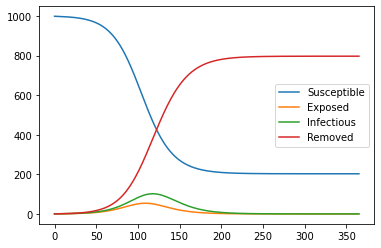

Final S=202.84877354031786
Final E=0.0008816806926817367
Final I=0.0033255798618343265
Final R=797.1470191991294


In [12]:
# numerical integration
ini_state = [S_0,E_0,I_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIR model
result = odeint(SEIR_EQ, ini_state, times, args=(beta_const, epsilon_const, gamma_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Exposed','Infectious', 'Removed'])
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final E={result[-1][1]}")
print(f"Final I={result[-1][2]}")
print(f"Final R={result[-1][3]}")

#### **考察**

このグラフから言えることは、

- 感染者人数のピークは総人口の10%程度である。
- 感染者(Infectious)のピークは約110日辺りで発生し、その後は感染が収束する。
- 終息までには220日ほど要する。
- E:潜伏期間を考慮すると（潜伏期間が0日以上であると）、ピーク時の感染者人数が小さくなり、収束が長くなることが分かる。

## SIS Model

風邪やインフルエンザなどの感染症の中には、長期的な免疫が得られないものがある。このような感染症は、感染から回復しても免疫力が得られず、再び感染可能者となる。

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}=-\beta S I + \gamma I\\ 
    \frac{d I}{d t}=\beta S I -\gamma I \\ 
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
\end{array}
$$

In [17]:
# Define differential equation of SIS model
def SIS_EQ(v, t, beta, gamma):
    # [v[0], v[1]] = [S, I]
    
    dS_dt = -beta * v[0] * v[1] + gamma * v[1]
    dI_dt = beta * v[0] * v[1] - gamma * v[1]
    
    return [dS_dt, dI_dt]    

In [22]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

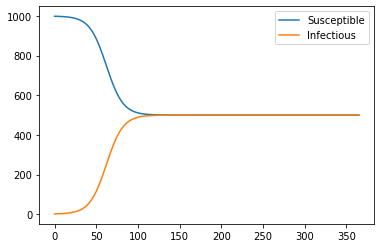

Final S=499.9999999564933
Final I=500.0000000435068


In [23]:
# numerical integration
ini_state = [S_0,I_0] 

# Numerical Solution using scipy.integrate
# Solver SIS model
result = odeint(SIS_EQ, ini_state, times, args=(beta_const, gamma_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious'])
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")

#### **考察**

このグラフから言えることは、
- 130日以降は、人口の半分ずつが感染者と非感染者の均衡状態が続く。
- 免疫を獲得しないため、永久に収束はしない。

## SIR Model + Population Movement

Vanilla SIRモデルでは、発病から回復し免疫を獲得した者と、発病から回復できず死亡した者を同一に含めて扱っていた。さらに、出生による人口増加を考慮していなかった。そこで、死亡率$\mu$ および出生率$\Lambda$ によって人口の増減を特徴付け、人口動態がある母集団の流行プロセスをモデリングする。

#### **パラメータ**

- $\mu K$: 出生数（出生率*固定値）
- $\delta$: 死亡率
- $\alpha$: 感染による死亡率増加分

※ $\mu K$について、シミュレーションは一年間を想定するため、人口の増減による出生率は変化しないと仮定し、今回は上の固定値を採用する。

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= \mu K - \beta S I - \delta S \\ 
    \frac{d I}{d t}= \beta S I - (\delta + \alpha) I - \gamma I \\ 
    \frac{d R}{d t}= \gamma I - \delta R
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \varepsilon: \text { 潜伏期間からの感染率 [1/day]} \\
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
    \mu K: \text { 出生数（1日あたり） } \\
    \delta: \text { 死亡率（1日あたり） } \\
    \alpha: \text { 感染による死亡率増加分 }\\
\end{array}
$$


**第1式の微分方程式**

ある出生数分だけの未感染者が一定の速度で増加し、また未感染者が一定の速度$\delta$で死亡し未感染者が減少する。

**第2式の微分方程式**

感染者は死亡リスクが増加するため、未感染時の死亡率に感染による死亡率増加分を加えた速度で感染者が死亡する。

**第3式の微分方程式**

免疫を獲得した未感染者が一定の速度$\delta$で死亡し減少する。

In [25]:
# Define differential equation of SIRd model
def SIRd_EQ(v, t, beta, gamma, muK, delta, alpha):
    # [v[0], v[1], v[2]] = [S, I, R]
    
    dS_dt = muK -beta * v[0] * v[1] - delta * v[0]
    dI_dt = beta * v[0] * v[1] - (delta+alpha) * v[1] - gamma * v[1]
    dR_dt = gamma * v[1] - delta * v[2]
    
    return [dS_dt, dI_dt, dR_dt]    

In [26]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
muK_const = 0.00002 * N
delta_const = 0.00003
alpha_const = 0.000015 # 感染すると、死亡率が1.5倍になる

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

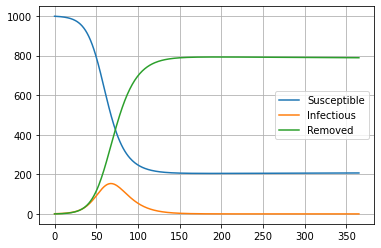

Final S=206.9401979043919
Final I=1.0048296045388334e-05
Final R=789.311306359909


In [27]:
# numerical integration
ini_state = [S_0,I_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIR model
result = odeint(SIRd_EQ, ini_state, times, 
                args=(beta_const, gamma_const, muK_const, delta_const, alpha_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")

#### **考察**

このグラフから言えることは、

- 感染者人数のピークは総人口の18%程度である。
- 人口動態を考慮すると、ピーク時の感染者人数が若干数小さくなり、収束にかかる日数が若干長くなる。収束した際の未感染者の数が増える。

## SIRS Model (SIR Model + Immune Loss)

Vanilla SIR Modelは、死亡や免疫獲得などでー旦系から取り除かれると二度と感染しない場合を想定している。しかし、伝染病によっては、免疫を失うなど、再び感染可能者になる場合がある。

#### **パラメータ**

- $\alpha$: 復元率（免疫を失う割合）


#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= \alpha R - \beta S I  \\ 
    \frac{d I}{d t}= \beta S I - \gamma I \\ 
    \frac{d R}{d t}= \gamma I - \alpha R
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 感染後死亡者、もしくは免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
    \alpha: \text { 復元率（免疫を失う割合） } \\
\end{array}
$$


**第1式の微分方程式**

免疫獲得者の内、免疫を失うことで感染可能者に戻る人が一定の速度$\alpha$で増加する。

**第3式の微分方程式**

免疫を失うことで感染可能者に戻る人が存在するため、一定の速度$\alpha$で減少する。

In [28]:
# Define differential equation of SIRi model
def SIRi_EQ(v, t, beta, gamma, alpha):
    # [v[0], v[1], v[2]] = [S, I, R]
    
    dS_dt = alpha * v[2] - beta * v[0] * v[1]
    dI_dt = beta * v[0] * v[1] - gamma * v[1]
    dR_dt = gamma * v[1] - alpha * v[2]
    
    return [dS_dt, dI_dt, dR_dt]    

In [39]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
alpha_const = 1/200 # 200日で免疫を失うとする。こういう設定で良いのか不明。

# A grid of time points (in days)
times = np.linspace(0, 1000,1000)

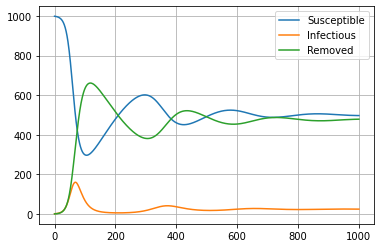

Final S=497.0726014140221
Final I=24.183870148977512
Final R=478.74352843700177


In [40]:
# numerical integration
ini_state = [S_0,I_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIR model
result = odeint(SIRi_EQ, ini_state, times, 
                args=(beta_const, gamma_const, alpha_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")

#### **考察**

このグラフから言えることは、

- 感染者人数のピークは総人口の18%程度である。
- 免疫獲得者は一定時間の経過後に免疫を失うため、収束するまでに長い年月を要する。
- 収束時は、およそ免疫獲得者と感染可能者は同等の人数となり、そのごく僅かな差分が感染者数となる。

## SIR Model + Birth + Death

集団への新規加入（新しく生まれた子供は全て未感染者$S$）と死亡がある場合のモデル

#### **パラメータ**

- $b$: 出生率
- $d$: 死亡率（S and R）
- $D$: 死亡率（感染者）$D>d$


#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= b(S+I+R) -\beta SI -dS \\ 
    \frac{d I}{d t}= \beta SI -\gamma I - DI\\ 
    \frac{d R}{d t}= \gamma I - d R
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 感染後死亡者、もしくは免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
    b: \text { 出生率 } \\
    d: \text { 死亡率（S and R）} \\
    D: \text { 死亡率（感染者）} \\
\end{array}
$$


**第1式の微分方程式**

$S,I,R$の状態に問わず、一定の速度$b$で出生数分の未感染者が増加する。

**第2式の微分方程式**

一定の速度$D$で死亡者が出る。また、出生数は$I$の人数に関与しないため、式に含めてはいけない。

**第3式の微分方程式**

一定の速度$d$で死亡者が出る。また、出生数は$R$の人数に関与しないため、式に含めてはいけない。

In [41]:
# Define differential equation of SIRbd model
def SIRbd_EQ(v, t, beta, gamma, b, d, D):
    # [v[0], v[1], v[2]] = [S, I, R]
    
    dS_dt = b*(v[0]+v[1]+v[2]) - beta*v[0]*v[1] - d*v[0]
    dI_dt = beta*v[0]*v[1] - gamma*v[1] - D*v[1]
    dR_dt = gamma*v[1] - d*v[2]
    
    return [dS_dt, dI_dt, dR_dt]    

In [46]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
b_const = 0.00002
d_const = 0.00003
D_const = 0.00003 + 0.000015

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

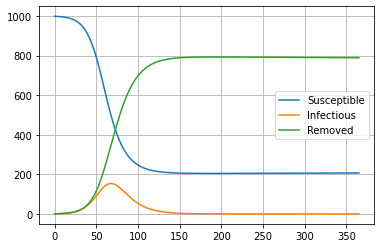

Final S=206.92732185699205
Final I=1.0045454040381708e-05
Final R=789.3102318430247


In [47]:
# numerical integration
ini_state = [S_0,I_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIRbd model
result = odeint(SIRbd_EQ, ini_state, times, 
                args=(beta_const, gamma_const, b_const, d_const, D_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")

## SIRD Model

SIRD Modelは、回復（具体的には、病気を生き延びて免疫を得た個体を意味する）と「死亡」を区別する。

#### **パラメータ**

- $\mu$: 死亡率

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= - \beta SI \\ 
    \frac{d I}{d t}= \beta SI -\gamma I - \mu I \\ 
    \frac{d R}{d t}= \gamma I \\
    \frac{d D}{d t}= \mu I
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 免疫を獲得した者 (Removed, Recovered) } \\ 
    D: \text { 死亡者 (Deceased) } \\
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
    \mu: \text { 死亡率 (The Death rate)} \\
\end{array}
$$

**第2式,第4式の微分方程式**

一定の速度$\mu$で死亡者が出る。

In [51]:
# Define differential equation of SIRD model
def SIRD_EQ(v, t, beta, gamma, mu):
    # [v[0], v[1], v[2], v[3]] = [S, I, R, D]
    
    dS_dt = - beta*v[0]*v[1] 
    dI_dt = beta*v[0]*v[1] - gamma*v[1] - mu*v[1]
    dR_dt = gamma*v[1]
    dD_dt = mu*v[1]
    
    return [dS_dt, dI_dt, dR_dt, dD_dt]

In [52]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
D_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0 - D_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
mu_const = 0.005

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

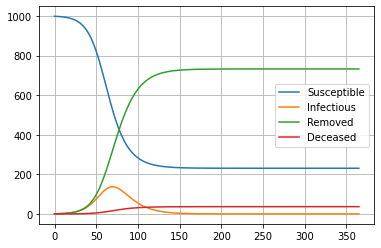

Final S=230.82487703443553
Final I=1.1104813251859812e-05
Final R=732.5477255816678


In [53]:
# numerical integration
ini_state = [S_0,I_0,R_0,D_0] 

# Numerical Solution using scipy.integrate
# Solver SIRbd model
result = odeint(SIRD_EQ, ini_state, times, 
                args=(beta_const, gamma_const,mu_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed', 'Deceased'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")
print(f"Final D={result[-1][3]}")

## SEIS Model

最後に免疫が獲得できないことを除けば、SEIRモデルと同様である。感染は免疫を残さないので、回復した個体は再び感受性のある状態に戻り、S区画に後退する。

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= -\beta SI + \gamma I \\ 
    \frac{d E}{d t}= \beta SI - \varepsilon E \\ 
    \frac{d I}{d t}= \varepsilon E - \gamma I \\ 
\end{array}
$$


$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    E: \text { 潜伏期間中の感染者 (Exposed) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \varepsilon: \text { 発症率（潜伏期間はこの逆数） [1/day]} \\
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
\end{array}
$$

In [57]:
# Define differential equation of SEIR model
def SEIS_EQ(v, t, beta, epsilon, gamma):
    # [v[0], v[1], v[2], v[3]] = [S, E, I]
    
    dS_dt = -beta*v[0]*v[2] + gamma*v[2]
    dE_dt = beta*v[0]*v[2] - epsilon*v[1]
    dI_dt = epsilon*v[1] - gamma*v[2]
    
    return [dS_dt, dE_dt, dI_dt]    

In [58]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
E_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - E_0 - I_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
epsilon_const = 1/5 # 潜伏期間を5日と仮定

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

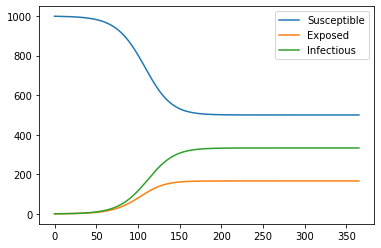

Final S=500.0000196674305
Final E=166.66666412775157
Final I=333.33331620481795


In [60]:
# numerical integration
ini_state = [S_0,E_0,I_0] 

# Numerical Solution using scipy.integrate
# Solver SIRS model
result = odeint(SEIS_EQ, ini_state, times, args=(beta_const, epsilon_const, gamma_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Exposed','Infectious', 'Removed'])
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final E={result[-1][1]}")
print(f"Final I={result[-1][2]}")

## SIRF Model

COVID-19の場合は感染の確定診断が難しく、特に初期においては確定診断前に亡くなる症例が多数報告された。こうした事例を反映させたモデルをSIRF Modelとする。$S^{*}$は確定診断がついた感染者、$\alpha_{1}$は$S^{*}$のうち確定診断の時点で亡くなっていた感染者の割合を示す。

$\alpha_{1}=0$ のとき、SIRF modelはSIRD modelに一致する。

Introduced in [COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-to-SIR-F) and [SIR-F model](https://qiita.com/Lisphilar/items/99c1e7673bc13d77dfcc)

#### **パラメータ**

- $\alpha_{1}$: Direct fatality probability of $S^{*}$ (non-dimentional)
- $\alpha_{2}$: Mortality rate of Infected cases [1/min]

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= - \beta SI \\ 
    \frac{d I}{d t}= (1-\alpha_{1})\beta SI - (\gamma+\alpha_{2}) I \\ 
    \frac{d R}{d t}= \gamma I \\
    \frac{d F}{d t}= \alpha_{1} \beta SI + \alpha_{2} I
\end{array}
$$

$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    R: \text { 免疫を獲得した者 (Removed, Recovered) } \\ 
    F: \text { 死亡者 (Fatal) } \\
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率、隔離率 (The Recovery rate) [1/day]} \\
    \alpha_{1}: \text { The direct fatality probability} \\
    \alpha_{2}: \text { The mortality rate of Infected cases} \\
\end{array}
$$

**第2式,第4式の微分方程式**

確定診断の時点で亡くなっていた感染者が確率$\alpha_1$で発生し、死亡する前に確定診断が出る感染者は$(1-\alpha_1)$で感染者区間に推移する。  
また、感染者は死亡率$\alpha_2$で死亡してしまう。


In [63]:
# Define differential equation of SIRF model
def SIRF_EQ(v, t, beta, gamma, alpha_1, alpha_2):
    # [v[0], v[1], v[2], v[3]] = [S, I, R, F]
    
    dS_dt = - beta*v[0]*v[1] 
    dI_dt = (1-alpha_1)*beta*v[0]*v[1] - (gamma+alpha_2)*v[1]
    dR_dt = gamma*v[1]
    dF_dt = alpha_1*beta*v[0]*v[1] + alpha_2*v[1]
    
    return [dS_dt, dI_dt, dR_dt, dF_dt]

In [68]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
F_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0 - F_0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
alpha_1_const = 0.1
alpha_2_const = 0.00003 + 0.000015

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

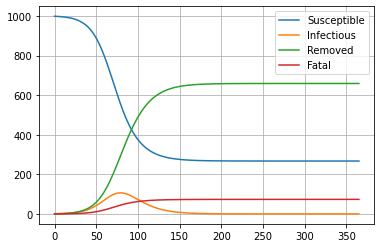

Final S=267.25710463330824
Final I=0.00011169322107396514
Final R=659.271821816984
Final F=73.47096185648675


In [69]:
# numerical integration
ini_state = [S_0,I_0,R_0,F_0] 

# Numerical Solution using scipy.integrate
# Solver SIRF model
result = odeint(SIRF_EQ, ini_state, times, 
                args=(beta_const, gamma_const, alpha_1_const, alpha_2_const))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Removed', 'Fatal'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final R={result[-1][2]}")
print(f"Final F={result[-1][3]}")

## SIQR Model

SIQRモデルでは、感染者と隔離者の区画を定義する。大規模な感染者数の最大値は検疫率に強く依存し、パンデミックの抑制には隔離措置がロックダウン措置よりも有効である。

- [Analysis of the outbreak of COVID-19 in Japan by SIQR model](https://pubmed.ncbi.nlm.nih.gov/32935071/)
- [SIQR モデルの表示](https://qiita.com/ekzemplaro/items/d4b079da3f172f6535b9)

#### 図が間違えている... gamma_q*Q

<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/instance/7516072/bin/gr1.jpg" width=50%>

#### **パラメータ**

- $q^{\prime}$: 感染直後の新規患者の一人当たりの検疫率 
- $q$: 症状の有無に関わらず、一人当たりの割合$q$で隔離され、集団に対して非感染となる。

症状があるかないかにかかわらず、一人当たりの割合qで隔離され、集団に対して非感染

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= - \beta SI \\ 
    \frac{d I}{d t}= (1-q^{\prime})\beta SI - qI - \gamma I \\ 
    \frac{d Q}{d t}= q^{\prime}\beta SI + qI - \gamma^{\prime}Q \\
    \frac{d R}{d t}= \gamma I + \gamma^{\prime}Q 
\end{array}
$$

$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    Q: \text { 隔離者 (Quarantined) } \\
    R: \text { 免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text { 回復率、除去率 (The Recovery rate) [1/day]} \\
    \gamma^{\prime}: \text { 隔離からの回復率 [1/day]} \\
    q^{\prime}: \text { 検疫率 } \\
    q: \text { 隔離率 } \\
\end{array}
$$

**第2式の微分方程式**

検疫を行なっていない感染者が加わり、感染後に隔離される感染者が減少する。

**第3式の微分方程式**

検疫により感染が発覚した、発症・未発症に関わらず隔離される感染者と、感染者の中から新たに隔離される感染者が加わる。また、隔離された状態で回復した者が、この$Q$区間を抜ける。

**第4式の微分方程式**

隔離された感染者と隔離されていない感染者からの回復者が、この$R$区間に移る。

In [2]:
# Define differential equation of SIQR model
def SIQR_EQ(v, t, beta, gamma, gamma_q, q_test, q):
    # [v[0], v[1], v[2], v[3]] = [S, I, Q, R]
    
    dS_dt = - beta*v[0]*v[1] 
    dI_dt = (1-q_test)*beta*v[0]*v[1] - q*v[1] - gamma*v[1]
    dQ_dt = q_test*beta*v[0]*v[1] + q*v[1] - gamma_q*v[2]
    dR_dt = gamma*v[1] + gamma_q*v[2]
    
    
    return [dS_dt, dI_dt, dQ_dt, dR_dt]

In [12]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
R_0 = 0
Q_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - Q_0 - R_0 

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta_const = (m*p)/N
gamma_const = 1/10
gamma_q_const = 1/10

# COVID-19などの場合、潜伏期間が長いため、q'をゼロに設定することができます。
q_test = 0  
q = 0.009

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

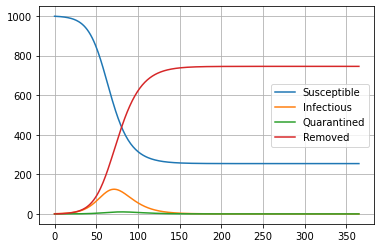

Final S=254.29201612661805
Final I=1.4027999026000905e-05
Final Q=3.016111640061393e-06
Final R=745.7079668292711


In [11]:
# numerical integration
ini_state = [S_0,I_0,Q_0,R_0] 

# Numerical Solution using scipy.integrate
# Solver SIQR model
result = odeint(SIQR_EQ, ini_state, times, 
                args=(beta_const, gamma_const, gamma_q_const, q_test, q))

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Infectious', 'Quarantined', 'Removed'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final I={result[-1][1]}")
print(f"Final Q={result[-1][2]}")
print(f"Final R={result[-1][3]}")

## SEIQJR Model

SEIQJRモデルでは、感染者と隔離者の区画に加え、ワクチン摂取による抗体保有への推移も定義する。

#### **パラメータ**

- $\gamma$: 検疫隔離率
- $\rho$: ワクチン接種率
- $\kappa$: 未発症からの発症率
- $\sigma$: 回復率
- $\mu$: 死亡率
- $\lambda$: 出生率

$\rho$と$\gamma$は、隔離比重$\alpha(t)$によりコントロールされる。
検疫とワクチン投与を行う機関が同一であるため、同時に同比重の作業は不可能である。この限られた医療資源を考慮する。

#### **数理モデル**

$$
\begin{array}{l}
    \frac{d S}{d t}= b(S+E+I+Q+J+R) - \beta (I+\varepsilon_{E}E+\varepsilon_{Q}Q+\varepsilon_{J}J)S -(\rho+\mu)S \\
    \frac{d E}{d t}= \beta (I+\varepsilon_{E}E+\varepsilon_{Q}Q+\varepsilon_{J}J)S - (\gamma_{1}+\kappa_{1}+\sigma_{1}+\mu)E \\
    \frac{d I}{d t}= \kappa_{1}E - (\gamma_2+\sigma_2+d_1+\mu)I \\
    \frac{d Q}{d t}= \gamma_1 E - (\kappa_2+\sigma_3+\mu)Q \\
    \frac{d J}{d t}= \gamma_2 I + \kappa_2 Q - (\sigma_4+d_2+\mu)J \\
    \frac{d R}{d t}= \rho S + \sigma_1 E + \sigma_2 I + \sigma_3 Q + \sigma_4 J - \mu R 
\end{array}
$$

$$
\begin{array}{ll}
    S: \text { 感染可能者 (Susceptible) } \\ 
    E: \text { 潜伏期間中の感染者 (Exposed) } \\ 
    I: \text { 感染者 (Infectious) } \\ 
    Q: \text { 隔離未感染者 (Quarantined-Infectious) } \\
    J: \text { 隔離感染者 (Quarantined-non-Infectious) } \\
    R: \text { 免疫を獲得した者 (Removed, Recovered) } \\ 
    \beta: \text { 接触あたりの感染率 (The infectious rate) [1/day]} \\ 
    \gamma: \text{検疫隔離率} \\
    \rho: \text{ワクチン接種率} \\
    \kappa: \text{未発症からの発症率} \\
    \sigma: \text{回復率} \\
    \mu: \text{死亡率} \\
    d: \text{病気による死亡率} \\
    b: \text{出生率} \\
    \varepsilon: \text{接触率} \\
\end{array}
$$

**第1式の微分方程式**

$S$は$I$,$E$,$Q$,$J$との接触により感染する。しかし、$Q$,$J$は隔離されており$S$との接触はないと判断できるため、各パラメータ$\varepsilon=0$とみなせる。

In [15]:
# Define differential equation of SEIQJR model
def SEIQJR_EQ(v, t, 
              beta, 
              gamma_1,
              gamma_2,
              rho,
              kappa_1,
              kappa_2,
              sigma_1,
              sigma_2,
              sigma_3,
              sigma_4,
              mu,
              d_1,
              d_2,
              b,
              epsilon_E,
              epsilon_Q,
              epsilon_J):

    # [v[0], v[1], v[2], v[3], v[4], v[5]] = [S, E, I, Q, J, R]
    
    dS_dt = b*(v[0]+v[1]+v[2]+v[3]+v[4]+v[5]) - beta*(v[2]+epsilon_E*v[1]+epsilon_Q*v[3]+epsilon_J*v[4])*v[0] - (rho+mu)*v[0]
    dE_dt = beta*(v[2]+epsilon_E*v[1]+epsilon_Q*v[3]+epsilon_J*v[4])*v[0] - (gamma_1+kappa_1+sigma_1+mu)*v[1]
    dI_dt = kappa_1*v[1] - (gamma_2+sigma_2+d_1+mu)*v[2]
    dQ_dt = gamma_1*v[1] - (kappa_2+sigma_3+mu)*v[3]
    dJ_dt = gamma_2*v[2] + kappa_2*v[3] - (sigma_4+d_2+mu)*v[4]
    dR_dt = rho*v[0] + sigma_1*v[1] + sigma_2*v[2] + sigma_3*v[3] + sigma_4*v[4] - mu*v[5]
    
    return [dS_dt, dE_dt, dI_dt, dQ_dt, dJ_dt, dR_dt]

In [52]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals.
I_0 = 1
E_0 = 0
Q_0 = 0
J_0 = 0
R_0 = 0
# Everyone else, S0, is susceptible to infection initially.
S_0 = N - E_0 - I_0 - Q_0 - J_0 - R_0 

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
m = 10 # 1日1人あたりのに接触平均数
p = 0.02 # 接触毎に感染が生じる1日あたりの確率
beta = (m*p)/N

alpha = 0.8
gamma_1 = 1/10 * alpha
gamma_2 = 3/10 * alpha
rho = 0.5 * (1-alpha)

kappa_1 = 1/5 # 潜伏期間は5日
kappa_2 = 1/3 # 発覚してからの潜伏期間は3日
sigma_1 = 1/7 # 回復するまで7日かかる
sigma_2 = 1/7
sigma_3 = 1/7
sigma_4 = 1/7

mu = 0.00003
d_1 = 0.000015 # 感染すると、死亡率が1.5倍になるように。d_1+d_2 = 1.5*d_1
d_2 = 0.000015 # 隔離されても死亡率は変化しないと仮定。
b = 0.00004
epsilon_E = 0.5 # 潜伏期間中の感染者と接触して、感染する確率は、発症者と接触する際と比べて0.5倍程度??
epsilon_Q = 0.000001
epsilon_J = 0.000001

# A grid of time points (in days)
times = np.linspace(0, 365, 365)

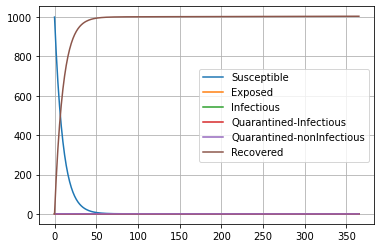

Final S=0.40130209002159184
Final E=-7.554497064428798e-18
Final I=3.745949686187568e-17
Final Q=9.480466109781356e-14
Final J=-9.489586421831542e-14
Final R=1003.255225781819


In [53]:
# numerical integration
ini_state = [S_0,E_0,I_0,Q_0,J_0,R_0] 

# Numerical Solution using scipy.integrate
result = odeint(SEIQJR_EQ, ini_state, times, 
                args=(
                    beta, gamma_1, gamma_2, rho, kappa_1, kappa_2,
                    sigma_1,sigma_2,sigma_3,sigma_4,mu,d_1,d_2,b,epsilon_E,epsilon_Q,epsilon_J)
               )

# plot
plt.figure()
plt.plot(times,result)
plt.legend(['Susceptible','Exposed','Infectious', 'Quarantined-Infectious', 'Quarantined-nonInfectious','Recovered'])
plt.grid()
plt.show()

print(f"Final S={result[-1][0]}")
print(f"Final E={result[-1][1]}")
print(f"Final I={result[-1][2]}")
print(f"Final Q={result[-1][3]}")
print(f"Final J={result[-1][4]}")
print(f"Final R={result[-1][5]}")

## Reference

- [新型コロナウィルス(CoVid-19)とSIRモデルについて](http://www.civil.kumamoto-u.ac.jp/keikaku//////blog/2020/photo/topic394-1.pdf)
- [奈良女子大学 伝染病](http://gi.ics.nara-wu.ac.jp/~takasu/lecture/old/archives/H18-global-8.pdf)
- [青山学院大学 中田行彦 SIRモデル](http://www.gem.aoyama.ac.jp/users/ynakata/class/2020/DEIII/DEIII8.pdf)
- [青山学院大学 中田行彦 SIRSモデル](http://www.gem.aoyama.ac.jp/users/ynakata/class/2020/DEIII/DEIII8.pdf)
- [感染症流行を予測する数理モデル SIR｜微分方程式によるシミュレーション](https://club.informatix.co.jp/?p=140)
- [感染症の数学予測モデル（SIRモデル）](https://www.rs.kagu.tus.ac.jp/~yokota/sir.html)
- [感染症数理モデルとCOVID-19](https://www.covid19-jma-medical-expert-meeting.jp/topic/3925)
- [Pythonプログラミング（ステップ６・SIRモデル）](https://wagtail.cds.tohoku.ac.jp/coda/python/p-6-application-sup-ode-sir-model.html): Scipyによる微分方程式の解の算出
- [TWITTERにおける
情報・関心の伝播モデルの構築](https://www.msi.co.jp/splus/tips/stuAward/2013pdf/muc13_ueda.pdf): SIRモデルを他の目的に使用した例
- [MSIRモデル](https://ja.wikipedia.org/wiki/MSIR%E3%83%A2%E3%83%87%E3%83%AB)

- [感染病の数学予測モデルの紹介　(SIRモデル）](https://qiita.com/kotai2003/items/3078f4095c3e94e5325c)

- [感染症数理モデル；Sequential SEIR model](https://biostat-hokudai.jp/seirmodel/)

